# <span style='font-family:"Times New Roman"'> <span styel=''>**WHOLE GENOME DOUBLING ANALYSIS**

*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we analyse all MSK-Imoact Cohort to know the proportion of WGD Samples, the tp53 mutated samples. Then we output a diagram with important information.

---

In [438]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

# MSK-Impact Cohort

## Size

In [439]:
# Loading the data
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.arm_level.txt', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.gene_level_grepTP53.txt', sep='\t')

The following cell shows the size of the total cohort through the different input files. We see that the cohort is more than 40 000 samples but only 38 465 have mutational information.

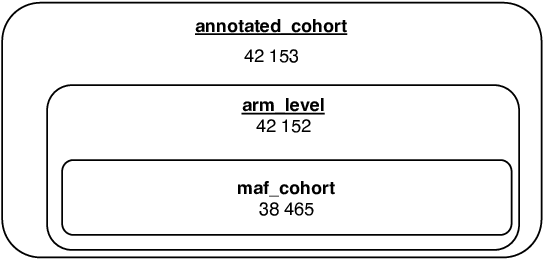

In [440]:
img = WImage(filename='total_cohort.pdf', resolution=150)
img

## WGD column
The annotated_cohort have a column called *wgd*. On the other side, for the TP53 mutated cohort, we computed the WGD states by hand. Let's see if the WGD column is accurate.

In [441]:
#Loading the master_file
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
#master = master[['Tumor_Id', 'wgd']]

In [442]:
annotated_cohort_wgd = annotated_cohort[['tumor_sample', 'wgd']]

In [58]:
# left merge 
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged.head()

,Tumor_Id,wgd_x,tumor_sample,wgd_y
0,P-0034223-T01-IM6,-1,P-0034223-T01-IM6,False
1,P-0009819-T01-IM5,-1,P-0009819-T01-IM5,False
2,P-0025956-T01-IM6,1,P-0025956-T01-IM6,True
3,P-0027408-T01-IM6,-1,P-0027408-T01-IM6,False
4,P-0006554-T01-IM5,-1,P-0006554-T01-IM5,False


In [232]:
len(set(annotated_cohort[annotated_cohort['purity'] >= 0.2].tumor_sample))

34491

Now the idea is to compare *wgd_x* and *wgd_y* to see if there are inconsistencies.

In [60]:
# We define a function to create a new column
def check_inconsistencies(x):
    if (x.wgd_x == 1 and x.wgd_y == True) or (x.wgd_x == -1 and x.wgd_y == False):
        return 0
    elif: return 1
    
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)

In [61]:
# now we sum the inconsistencies column to see if we have any inconsistency. We should have 0 for no inconsitencies at all.
merged.inconsistencies.sum()

121

So we have 121 samples with problems: let's take a look.

In [70]:
merged[merged['inconsistencies'] == 1][~merged.wgd_y.isna()]

,Tumor_Id,wgd_x,tumor_sample,wgd_y,inconsistencies
2596,P-0011205-T03-IM6,-1,P-0011205-T03-IM6,True,1
3906,P-0035720-T01-IM6,-1,P-0035720-T01-IM6,True,1
4201,P-0020803-T02-IM6,-1,P-0020803-T02-IM6,True,1
6153,P-0022193-T02-IM6,-1,P-0022193-T02-IM6,True,1
11524,P-0016952-T02-IM6,-1,P-0016952-T02-IM6,True,1
20395,P-0005192-T01-IM5,-1,P-0005192-T01-IM5,True,1
21326,P-0018318-T01-IM6,-1,P-0018318-T01-IM6,True,1
23992,P-0031102-T06-IM6,-1,P-0031102-T06-IM6,True,1
26782,P-0046593-T02-IM6,-1,P-0046593-T02-IM6,True,1
27950,P-0031010-T03-IM6,-1,P-0031010-T03-IM6,True,1


We see that those inconsistencies come from the fact that some tumor samples have different Normal matched with one of them being with a WGD. They annotate the sample as a WGD sample.

So let's filter annotated_cohort - keep the highest purity matched normal - and see if the inconsistencies are still present.

In [443]:
def normal_samp_duplicates_filter(df, sample_name, purity_name):
    '''
    This function aims to filter out the samples that have the same tumor id but different normal samples.
    We choose to keep only the one with the highest purity in case of duplicates.
    
    Arguments:
        - df: the dataframe we want to clean
        - sample_name: the name of the column containing the sample. Ex: P-0006554-T01-IM5_P-0006554-N01-IM5
        - purity_name: the name of the column containing the purity
    '''
    
    # We first restrain to the interesting columns
    sub_df = df[[sample_name, purity_name]]
    #Create the column with the tumor_id and set it as index to identify the duplicates
    sub_df['Tumor_Id'] = sub_df[sample_name].str[:17]
    sub_df = sub_df.set_index('Tumor_Id')
    # We use the duplicated() method to create a False/True Series if the sample is duplicated
    duplicates_series = sub_df[sample_name].str[:17].duplicated()
    # We then select only samples that are duplicated to obtain the list of duplicated samples
    duplicated_samples = list(duplicates_series[duplicates_series == True].index)

    # We put the sample_name column as Index
    sub_df = sub_df.set_index(sample_name)

    # We can now filter out the samples that are listed in duplicated_samples
    to_be_filtered = []
    for sample in duplicated_samples:
        to_be_filtered.append(sub_df[sub_df.index.str[:17] == sample][['purity']].idxmin()['purity'])
    
    #print(to_be_filtered)
    # Now we filter out the lines that are in the list
    df = df[~df[sample_name].isin(to_be_filtered)]
    
    return df

In [152]:
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
annotated_cohort_filt = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

In [162]:
annotated_cohort_wgd = annotated_cohort_filt[['tumor_sample', 'wgd']]
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)
merged[merged['inconsistencies'] == 1]#[~merged.wgd_y.isna()]

,Tumor_Id,wgd_x,tumor_sample,wgd_y,inconsistencies
495,P-0031435-T01-IM6,-1,NaN,NaN,1
1282,P-0010672-T02-IM5,-1,NaN,NaN,1
1855,P-0027242-T01-IM6,-1,NaN,NaN,1
2906,P-0013827-T01-IM5,-1,NaN,NaN,1
2957,P-0010083-T01-IM5,-1,NaN,NaN,1
3263,P-0020798-T01-IM6,-1,NaN,NaN,1
3271,P-0017938-T01-IM6,-1,NaN,NaN,1
3284,P-0031170-T01-IM6,-1,NaN,NaN,1
3898,P-0035720-T01-IM6,-1,P-0035720-T01-IM6,True,1
3980,P-0036528-T01-IM6,-1,NaN,NaN,1


**Conclusion:** We will keep the *wgd* column as the reference for wgd.

# Filtering the annotated_data
1. We do not want duplicates in Tumor_Id
2. As maf_cohort is necessary to know if we have tp53 mutants or not, we will reduce our analysis to the samples of maf_cohort (loss of ~3 600 samples over 42 153)
3. Moreover, we need to access tp53 cn state, so we have to be sure all samples are in gene_level file
4. As we did for the TP53 cohort, we will filter samples with purity < 0.2 BUT we will rescue TP53 mutants with no purity a tp53_vaf > 0.15
5. We remove samples with INDETERMINATE copy number state
6. Finally we remove samples in WGD cohort

In [466]:
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.gene_level_grepTP53.txt', sep='\t')

maf_samples = list(set(maf_cohort.Tumor_Sample_Barcode))

annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
cohort = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

# We take only samples that are in maf_samples
cohort = cohort[cohort.tumor_sample.isin(maf_samples)]

# Finally we want to be able to accesss the TP53 locus copy number state, so we need to make sure all samples are
# in gene_level

# We remove the following samples that are not in gene_level file
cohort = cohort[~cohort.tumor_sample.isin(['P-0000157-T01-IM3','P-0000158-T01-IM3','P-0000204-T01-IM3','P-0000206-T01-IM3','P-0000273-T01-IM3','P-0000308-T01-IM3','P-0000320-T01-IM3','P-0000396-T01-IM3','P-0007206-T01-IM5','P-0011437-T01-IM5','P-0037557-T01-IM6','P-0043334-T01-IM6','P-0043373-T01-IM6','P-0043377-T01-IM6','P-0045294-T01-IM6','P-0045404-T01-IM6'])]


# Now we filter on purity

# We create a list for the interesting samples that we will integrate to our data
cohort_na_tp53 = maf_cohort[(maf_cohort.purity == 0.3) | (maf_cohort.purity.isna())][maf_cohort['Hugo_Symbol'] == 'TP53']
samples_maxvaf=[]
for sample in list(set(cohort_na_tp53.Tumor_Sample_Barcode)):
    sample_1 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'] == sample]
    if max(sample_1.t_var_freq)>0.15:
        samples_maxvaf.append(sample)    
# we remove THE sample that have a tp53_vaf < 2%
samples_maxvaf.remove('P-0035205-T03-IM6')

# Samples with purity > 0.2
samples_purity = list(set(maf_cohort[maf_cohort['purity'] > 0.2].Tumor_Sample_Barcode))

samples = samples_maxvaf + samples_purity
samples.remove('P-0016457-T04-IM6')
samples.remove('P-0014703-T01-IM6')

cohort = cohort[cohort.tumor_sample.isin(samples)]

# Removing INDETERMINATE tp53 CN state samples
gene_level_ = gene_level[gene_level['gene'] == 'TP53']
samples_ind = list(set(gene_level_[gene_level_['cn_state'] == 'INDETERMINATE']['sample']))


cohort = cohort[~cohort.sample_id.isin(samples_ind)]


# Now we will filter out NA purity or NA tp53 vaf samples that are in WGD cohort
# We will also remove uncertain/inconsistent tp53 CN
cohort_wgd = cohort[cohort['wgd'] == 1]
samples_wgd = list(set(cohort_wgd.tumor_sample))
samples_matched_wgd = list(set(cohort_wgd.sample_id))

gene_level_tp53_wgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_wgd)]
gene_level_tp53_wgd['tumor_id'] = gene_level.apply(lambda x: x['sample'][:17], axis=1)


# Let's see how many samples are gathered in these cn_state
to_filter = ['CNLOH', 'GAIN', 'DIPLOID', 'AMP (LOH)', 'HETLOSS',
             'CNLOH & GAIN', 'AMP', 'LOSS & GAIN', 'AMP (BALANCED)',
            'HOMDEL', 'LOSS BEFORE & AFTER']

gene_level_tp53_wgd_ = gene_level_tp53_wgd[~gene_level_tp53_wgd.cn_state.isin(to_filter)]
samples = list(set(gene_level_tp53_wgd_.tumor_id))

samples_filt = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd.cn_state.isin(to_filter)].tumor_id))

maf_cohort_wgd_ = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples)]
cohort_wgd_ = cohort[cohort.tumor_sample.isin(samples)]
samples_napur = maf_cohort_wgd_[maf_cohort_wgd_['purity'].isna()].Tumor_Sample_Barcode.tolist()
samples_natp53vaf = maf_cohort[maf_cohort['Hugo_Symbol'] == 'TP53'][maf_cohort['t_var_freq'].isna()].Tumor_Sample_Barcode.tolist()

samples_tofilter = samples_filt + samples_napur + samples_natp53vaf


cohort = cohort[~cohort.tumor_sample.isin(samples_tofilter)]


In [467]:
print('Final size of our cohort: ' + str(len(list(cohort.tumor_sample))))

maf_cohort_study = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(list(cohort.tumor_sample))]
print('\nWe verify that purity>0.2 in our maf_cohort file:')
print(maf_cohort_study[maf_cohort_study.Tumor_Sample_Barcode.isin(samples_purity)].purity.min())

Final size of our cohort: 28830

We verify that purity>0.2 in our maf_cohort file:
0.200051999476184


In [6]:
with open('samples_cohort.pkl', 'wb') as f:
    pickle.dump(list(cohort.tumor_sample), f)

In [448]:
cohort

,sample_id,sample_path,fit_to_use,patient,tumor_sample,tumor_bamname,normal_sample,normal_bamname,tag,run_prefix,run_output_dir,run_log_dir,counts_file,has_counts_file,has_hisens_run,has_purity_run,has_qc,has_maf_anno,run_status,tumor_sample_id,path,fit_name,purity_run_version,purity_run_prefix,purity_run_Seed,purity_run_cval,purity_run_nhet,purity_run_snp_nbhd,purity_run_ndepth,purity_run_Purity,purity_run_Ploidy,purity_run_dipLogR,purity_run_alBalLogR,hisens_run_version,hisens_run_prefix,hisens_run_Seed,hisens_run_cval,hisens_run_nhet,hisens_run_snp_nbhd,hisens_run_ndepth,hisens_run_hisens,hisens_run_Ploidy,hisens_run_dipLogR,manual_note,is_best_fit,purity,ploidy,dipLogR,dipLogR_flag,n_alternative_dipLogR,wgd,n_dip_bal_segs,frac_dip_bal_segs,n_dip_imbal_segs,frac_dip_imbal_segs,n_amps,n_homdels,frac_homdels,n_homdels_clonal,frac_homdels_clonal,n_cn_states,n_segs,n_cnlr_clusters,n_lcn_na,n_loh,frac_loh,n_segs_subclonal,frac_segs_subclonal,n_segs_below_dipLogR,frac_below_dipLogR,n_segs_balanced_odd_tcn,frac_balanced_odd_tcn,n_segs_imbalanced_diploid_cn,frac_imbalanced_diploid_cn,n_segs_lcn_greater_mcn,frac_lcn_greater_mcn,n_snps,n_het_snps,frac_het_snps,n_snps_with_300x_in_tumor,n_het_snps_with_300x_in_tumor,n_het_snps_hom_in_tumor_1pct,n_het_snps_hom_in_tumor_5pct,frac_het_snps_hom_in_tumor_1pct,frac_het_snps_hom_in_tumor_5pct,mean_cnlr_residual,sd_cnlr_residual,n_segs_discordant_tcn,frac_discordant_tcn,n_segs_discordant_lcn,frac_discordant_lcn,n_segs_discordant_both,frac_discordant_both,n_segs_icn_cnlor_discordant,frac_icn_cnlor_discordant,mafr_median_all,mafr_median_clonal,mafr_n_gt_1,facets_suite_version,facets_qc_version,homdel_filter_pass,diploid_bal_seg_filter_pass,diploid_imbal_seg_filter_pass,waterfall_filter_pass,hyper_seg_filter_pass,high_ploidy_filter_pass,valid_purity_filter_pass,diploid_seg_filter_pass,em_cncf_icn_discord_filter_pass,dipLogR_too_low_filter_pass,subclonal_genome_filter_pass,icn_allelic_state_concordance_filter_pass,contamination_filter_pass,facets_qc,arm_level_file,gene_level_file,ccf_file,arm_level_file_exists,gene_level_file_exists,ccf_file_exists
0,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,NaN,P-0034223,P-0034223-T01-IM6,JU212898-T,P-0034223-N01-IM6,NL131958-N,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/default/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/default/logs/,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/countsMerged____P-0034223-T01-IM6_P-0034223-N01-IM6.dat.gz,True,True,True,False,False,complete,P-0034223-T01-IM6_P-0034223-N01-IM6,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6/,default,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6_purity,100,100,15,250,35,0.94,2.2,-0.16,-0.16,0.5.14,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6_hisens,100,50,15,250,35,NaN,2.2,-0.16,NaN,False,0.941111,2.241830,-0.155483,False,0,False,12,0.590,0,0.000,0,0,0.0000,0,0.0000,6,31,10,2,4,0.062,1,0.000011,11,0.26,0,0.000000,0,0.000,7,0.110,22963,2655,0.12,6450,634,43,80,0.01600,0.0300,-0.190,0.63,1,0.0038,0.0,0.00,0,0.0000,1,0.0420,0.0042,0.00340,5,2.0.5,1,True,True,False,True,True,True,True,True,True,True,True,True,True,True,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM6.arm_level.txt,/juno/work/ccs/shared/resources/impact/facets/all/P-00342/P-0034223-T01-IM6_P-0034223-N01-IM6//default/P-0034223-T01-IM6_P-0034223-N01-IM

Now we have unique tumor_sample, we can begin the analysis

# Non WGD

## PLot of the number of mutations + LOH Status

# WGD 

## WGD Proportion

In [469]:
print('Number of samples with WGD: ' + str(cohort[cohort['wgd'] == True].shape[0]) + ' - ' + str(round(100* cohort[cohort['wgd'] == True].shape[0]/cohort.shape[0],2))+ ' %')
print('Number of samples without WGD: ' + str(cohort[cohort['wgd'] == False].shape[0])  + ' - ' + str(round(100* cohort[cohort['wgd'] == False].shape[0]/cohort.shape[0],2))+ ' %')

Number of samples with WGD: 9898 - 34.33 %
Number of samples without WGD: 18932 - 65.67 %


In [470]:
# We filter only WGD Samples
cohort_wgd = cohort[cohort['wgd'] == 1]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_wgd = list(set(cohort_wgd.tumor_sample))
samples_matched_wgd = list(set(cohort_wgd.sample_id))

In [471]:
# We filter the maf_cohort on the wgd samples
maf_cohort_wgd = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples_wgd)]

## Verify that we have filtered out uncertain tp53 cn_state
Further in the analysis, we will need to time TP53 mutations. This timing highly rely on TP53 copy number states. The problem is that we have some inconistencies between gene_level cn_state and the WGD state ie we have *CNLOH* at tp53 locus while we should have *CNLOH BEFORE* or *CNLOH AFTER*... 

Consequently we want to filter out all samples with uncertain/inconsistent copy number state at tp53 locus.

Moreover we filter out all NaN purity and NaN VAF samples

In [472]:
# We show the distribution of CN state withtin the WGD cohort
gene_level_tp53_wgd = gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].isin(samples_matched_wgd)]
gene_level_tp53_wgd['tumor_id'] = gene_level.apply(lambda x: x['sample'][:17], axis=1)

In [473]:
# Let's take a look to all cn_state
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,4860
CNLOH BEFORE & LOSS,1887
LOSS AFTER,1275
TETRAPLOID,651
DOUBLE LOSS AFTER,531
CNLOH BEFORE,464
CNLOH AFTER,146
CNLOH BEFORE & GAIN,84


We have filtered out the following cn_state that are inconsistent with a WGD state:
* CNLOH
* GAIN
* DIPLOID
* AMP (LOH)
* HETLOSS
* CNLOH & GAIN
* AMP
* LOSS & GAIN
* AMP (BALANCED)
* HOMDEL

Additionnaly we have filtered *LOSS BEFORE & AFTER* because it is impossible to know the timing of the mutation with this cn_state.

Now we filter out all NaN purity and VAF samples from cohort_wgd :

In [474]:
# We check the length of cohort_wgd 
cohort_wgd.shape[0]

9898

## LOH status creation

1. We define LOH (Loss of Heterozygosity) as having lost the second allele, which in practice is traduced numerically by having a lcn (low copy number) of 0.

First, le's take a look at the different TP53 Copy Number states involved in our WGD cohort:

In [331]:
# We show the distribution of CN state withtin the WGD cohort
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,4860
CNLOH BEFORE & LOSS,1887
LOSS AFTER,1275
TETRAPLOID,651
DOUBLE LOSS AFTER,531
CNLOH BEFORE,464
CNLOH AFTER,146
CNLOH BEFORE & GAIN,84


We identify here that we have 3 major CN states: *LOSS BEFORE*, *CNLOH BEFORE & LOSS* and *LOSS AFTER*.
Moreover we identify the CN states leading to a LOH:
* LOSS BEFORE
* CNLOH BEFORE & LOSS
* CNLOH BEFORE
* CNLOH BEFORE & GAIN

**This is strictly equivalent to say lcn = 0 (lower copy number)**

So we're able to identify LOH samples and compute the proportion of LOH:

In [332]:
%%time
def get_loh(x):
    if gene_level_tp53_wgd[gene_level_tp53_wgd['sample'] == x.sample_id]['cn_state'].values[0] in ['LOSS BEFORE', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS BEFORE & AFTER', 'CNLOH BEFORE & GAIN']:
        return True
    else: return False
                                                                                                                
# we create a new column named LOH in our cohort_wgd
cohort_wgd['LOH'] = cohort_wgd.apply(get_loh, axis=1)
get_groupby(cohort_wgd, 'LOH', 'count')

CPU times: user 10.6 s, sys: 28.7 ms, total: 10.6 s
Wall time: 10.6 s


,count
LOH,
False,2603
True,7295


In [333]:
n_loh = len(set(cohort_wgd[cohort_wgd['LOH'] == True].tumor_sample))
n_noloh = len(set(cohort_wgd[cohort_wgd['LOH'] == False].tumor_sample))
total = len(set(cohort_wgd.tumor_sample)) 

print('Number of LOH samples in WGD cohort: ' + str(n_loh) + ' - ' + str(round(100*n_loh/total, 2)) + ' %')
print('Number of non LOH samples in WGD cohort: ' + str(n_noloh) + ' - ' + str(round(100*n_noloh/total, 2)) + ' %')

Number of LOH samples in WGD cohort: 7295 - 73.7 %
Number of non LOH samples in WGD cohort: 2603 - 26.3 %


In [334]:
# We count the samples that has at least one tp53 mutation
total = len(set(maf_cohort_wgd.Tumor_Sample_Barcode))
n = len(set(maf_cohort_wgd[maf_cohort['Hugo_Symbol'] == 'TP53'].Tumor_Sample_Barcode))
print('Number of TP53 mutated samples in WGD setting: ' + str(n) + ' - ' + str(round(100*n/len(cohort_wgd),2)) + ' %')
print('Number of TP53 wild-type samples in WGD setting: ' + str(total - n) + ' - ' + str(100 -round(100*n/len(cohort_wgd),2)) + ' %')

Number of TP53 mutated samples in WGD setting: 6703 - 67.72 %
Number of TP53 wild-type samples in WGD setting: 3195 - 32.28 %


## Creation of tp53_count column

In [335]:
%%time
# First we need to create a sample_mut_key to identify duplicated mutations
maf_cohort_wgd['mut_key'] = maf_cohort_wgd.apply(lambda h: str(h.Chromosome)+'_'+str(h.Start_Position)+'_'+str(h.Reference_Allele)+'_'+str(h.Tumor_Seq_Allele2), axis=1) 

# Create a sample key to differentiate duplicates
maf_cohort_wgd['sample_mut_key'] = maf_cohort_wgd.apply(lambda h: h.Tumor_Sample_Barcode + h.mut_key, axis = 1)

CPU times: user 7.84 s, sys: 377 ms, total: 8.21 s
Wall time: 8.23 s


In [336]:
%%time
# Here we count the number of tp53 mutations per sample
def get_tp53_count(x):
    h = maf_cohort_wgd[maf_cohort_wgd['Tumor_Sample_Barcode'] == x.tumor_sample][maf_cohort_wgd['Hugo_Symbol'] == 'TP53']
    h.drop_duplicates(subset='sample_mut_key')
    return h.shape[0]

cohort_wgd['tp53_count'] = cohort_wgd.apply(get_tp53_count, axis=1)

CPU times: user 2min 3s, sys: 393 ms, total: 2min 3s
Wall time: 2min 3s


## Plot of the number of mutations + LOH Status
Here we create a column *tp53_count* and compute the plot of the number of tp53 mutation per samples colorcoded by LOH status

,NO LOH,LOH
tp53_count,,
0,1870.0,1325.0
1,476.0,5841.0
>=2,257.0,129.0


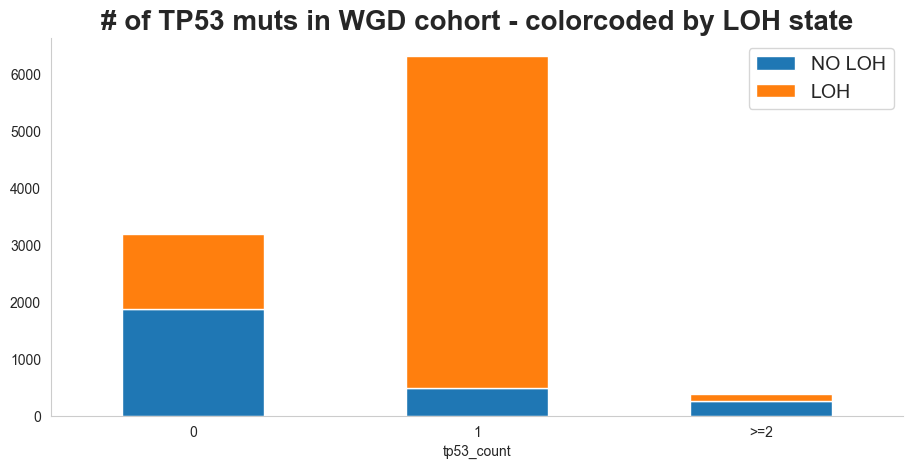

In [337]:
# First we need to groupby our cohort_wgd file to have the size of the different groups
loh_tp53count = pd.DataFrame(cohort_wgd[['tp53_count', 'LOH']].groupby(['tp53_count', 'LOH']).size()).unstack()
loh_tp53count = loh_tp53count.fillna(0)
loh_tp53count.columns=['NO LOH', 'LOH']
loh_tp53count.loc['>=2'] = [loh_tp53count['NO LOH'][2:].sum(),loh_tp53count['LOH'][2:].sum()]
loh_tp53count = loh_tp53count.drop([2,3,4,5],axis=0)
display(loh_tp53count)

sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = loh_tp53count.plot(kind = 'bar', stacked=True, ax=ax)
ax.set_xticklabels(['0', '1','>=2'], rotation=0)
ax.legend(['NO LOH', 'LOH'], fontsize=14)
ax.set_title('# of TP53 muts in WGD cohort - colorcoded by LOH state',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

So we see an enrichment of LOH in samples with 1 tp53 mutation. The questions are:
* What are the TP53 states involved in this LOH state? LOSS ? CNLOH ? 
    * For the different tp53 mutation count categories (0,1,>=2)

## WGD - TP53

In [338]:
cohort_wgd.shape[0]

9898

In [339]:
# We define gene_level_tp53 which represents gene level filtered on tp53 locus
gene_level_tp53 = gene_level[gene_level['gene'] == 'TP53']
wgd_tp53_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] >= 1].sample_id))
print('WGD - TP53: ' + str(len(wgd_tp53_samples)) + ' - ' + str(round(100*len(wgd_tp53_samples)/cohort_wgd.shape[0],2)) + ' %')


WGD - TP53: 6703 - 67.72 %


### WGD - TP53 - LOH

In [340]:
wgd_tp53_loh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == True][cohort_wgd['tp53_count'] >= 1].sample_id))
gene_level_tp53_wgd_loh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_loh_samples)]

In [341]:
print('WGD - TP53 - LOH: ' + str(len(wgd_tp53_loh_samples)) + ' - ' + str(round(100*len(wgd_tp53_loh_samples)/len(wgd_tp53_samples),2)) + ' %')
      

WGD - TP53 - LOH: 5970 - 89.06 %


In [342]:
h = get_groupby(gene_level_tp53_wgd_loh, 'cn_state', 'count')
LOSS = h['count']['LOSS BEFORE']
CNLOH = h.sum().values[0] - h['count']['LOSS BEFORE']
print('Number of LOSS: ' + str(LOSS) + ' - ' + str(round(100*LOSS/h.sum().values[0],2)) + ' %')
print('Number of CNLOH: ' + str(CNLOH) + ' - ' + str(round(100*CNLOH/h.sum().values[0],2)) + ' %')
h

Number of LOSS: 3876 - 64.92 %
Number of CNLOH: 2094 - 35.08 %


,count
cn_state,
CNLOH BEFORE,420
CNLOH BEFORE & GAIN,80
CNLOH BEFORE & LOSS,1594
LOSS BEFORE,3876


In [343]:
# Counting the multi tp53 mutations samples in CNLOH and LOSS
samples_LOSS = list(gene_level_tp53_wgd_loh[gene_level_tp53_wgd_loh.cn_state.isin(['LOSS BEFORE'])]['sample'].str[:17])
samples_LOH = list(gene_level_tp53_wgd_loh[~gene_level_tp53_wgd_loh.cn_state.isin(['LOSS BEFORE'])]['sample'].str[:17])

print('Number of >=2muts samples in LOH: ' + str(cohort_wgd[cohort_wgd['tumor_sample'].isin(samples_LOH)][cohort_wgd['tp53_count'] >= 2].shape[0]))
print('Number of >=2muts samples in LOSS: ' + str(cohort_wgd[cohort_wgd['tumor_sample'].isin(samples_LOSS)][cohort_wgd['tp53_count'] >= 2].shape[0]))

Number of >=2muts samples in LOH: 58
Number of >=2muts samples in LOSS: 71


### WGD - TP53 - No LOH

In [344]:
wgd_tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] >= 1].sample_id))
gene_level_tp53_wgd_noloh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_noloh_samples)]

In [345]:
print('WGD - TP53 - No LOH: ' + str(len(wgd_tp53_noloh_samples)) + ' - ' + str(round(100*len(wgd_tp53_noloh_samples)/len(wgd_tp53_samples),2)) + ' %')
      

WGD - TP53 - No LOH: 733 - 10.94 %


In [346]:
# Samples with One mutation
wgd_1tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] == 1].sample_id))
print( 'Number of WGD - 1tp53 - No LOH: ' + str(len(wgd_1tp53_noloh_samples)) + ' - '+ str(round(100*len(wgd_1tp53_noloh_samples)/len(wgd_tp53_noloh_samples), 2)) + ' %')

Number of WGD - 1tp53 - No LOH: 476 - 64.94 %


In [347]:
# Samples with >=2 mutations
wgd_2tp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['LOH'] == False][cohort_wgd['tp53_count'] >= 2].sample_id))
print( 'Number of WGD - >=2 tp53 - No LOH: ' + str(len(wgd_2tp53_noloh_samples)) + ' - '+ str(round(100*len(wgd_2tp53_noloh_samples)/len(wgd_tp53_noloh_samples), 2)) + ' %')


Number of WGD - >=2 tp53 - No LOH: 257 - 35.06 %


## WGD - No TP53

In [348]:
wgd_notp53_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0].sample_id))
gene_level_tp53_wgd_notp53 = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_samples)]

In [349]:
print('WGD - No TP53: ' + str(len(wgd_notp53_samples)) + ' - ' + str(round(100*len(wgd_notp53_samples)/cohort_wgd.shape[0],2)) + ' %')

WGD - No TP53: 3195 - 32.28 %


### WGD - No TP53 - No LOH

In [350]:
# Now we count the number of samples with WGD - No TP53 mut - No LOH
wgd_notp53_noloh_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0][cohort_wgd['LOH'] == False].sample_id))
gene_level_tp53_wgd_notp53_noloh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_noloh_samples)]
print('WGD - No TP53 - No LOH : ' + str(len(wgd_notp53_noloh_samples)) + ' - ' + str(round(100*len(wgd_notp53_noloh_samples)/len(wgd_notp53_samples), 2)) + ' %')

WGD - No TP53 - No LOH : 1870 - 58.53 %


In [351]:
# What are the different CN_states
get_groupby(gene_level_tp53_wgd_notp53_noloh, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS AFTER,890
TETRAPLOID,527
DOUBLE LOSS AFTER,395
CNLOH AFTER,58


### WGD - No TP53 - LOH

In [352]:
# Now we count the number of samples with WGD - No TP53 mut - LOH
wgd_notp53_loh_samples = list(set(cohort_wgd[cohort_wgd['tp53_count'] == 0][cohort_wgd['LOH'] == True].sample_id))
gene_level_tp53_wgd_notp53_loh = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_notp53_loh_samples)]
print('WGD - No TP53 - LOH : ' + str(len(wgd_notp53_loh_samples)) + ' - ' + str(round(100*len(wgd_notp53_loh_samples)/len(wgd_notp53_samples), 2)) + ' %')

WGD - No TP53 - LOH : 1325 - 41.47 %


Let's dig in the different Copy Number States involved in the *WGD - No TP53 - LOH* subcohort

In [353]:
h = get_groupby(gene_level_tp53_wgd_notp53_loh, 'cn_state', 'count')
LOSS = h['count']['LOSS BEFORE'] 
CNLOH = h.sum().values[0] - h['count']['LOSS BEFORE'] 
print('Number of LOSS: ' + str(LOSS) + ' - ' + str(round(100*LOSS/h.sum().values[0],2)) + ' %')
print('Number of CNLOH: ' + str(CNLOH) + ' - ' + str(round(100*CNLOH/h.sum().values[0],2)) + ' %')
h

Number of LOSS: 984 - 74.26 %
Number of CNLOH: 341 - 25.74 %


,count
cn_state,
CNLOH BEFORE,44
CNLOH BEFORE & GAIN,4
CNLOH BEFORE & LOSS,293
LOSS BEFORE,984


# Timing TP53 mutations

In [354]:
# We begin by defining the WGD - TP53 Cohort

gene_level_tp53 = gene_level[gene_level['gene'] == 'TP53']

cohort_wgd_tp53 = cohort_wgd[cohort_wgd['tp53_count'] >= 1]
wgd_tp53_samples = list(set(cohort_wgd_tp53.sample_id))
wgd_tp53_tumors = list(set(cohort_wgd_tp53.tumor_sample))

gene_level_tp53_wgd = gene_level_tp53[gene_level_tp53['sample'].isin(wgd_tp53_samples)]
maf_cohort_wgd_tp53 = maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(wgd_tp53_tumors)][maf_cohort['Hugo_Symbol'] == 'TP53']

In [355]:
print('Total number of mutations in WGD - TP53: ' + str(maf_cohort_wgd_tp53.shape[0]))

Total number of mutations in WGD - TP53: 7118


We will add a  column to **maf_cohort_wgd_tp53** called *tp53_res*.

In [356]:
%%time

def get_tp53_res(x):
    tumor = x.Tumor_Sample_Barcode
    pur = x.purity
    vaf = x.t_var_freq
    tcn = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['tcn'].values[0]
    
    tp53_exp_nb = (vaf/pur) * (tcn * pur + 2 * (1 - pur))
    tp53_res = tcn - tp53_exp_nb
    
    return tp53_res

maf_cohort_wgd_tp53['tp53_res'] = maf_cohort_wgd_tp53.apply(get_tp53_res, axis=1)

CPU times: user 16.1 s, sys: 69.6 ms, total: 16.2 s
Wall time: 16.2 s


Let's have a look to the distribution of tp53_res:

In [357]:
maf_cohort_wgd_tp53.tp53_res.isna().sum()#describe()

0

We see that we have 25% of our tp53 mutations with a negative tp53_res. What does that mean?

Basically, having a look to the computation to reach tp53_res, there are two main actors: the *vaf* and the *purity*. If the purity is low, then we will have a low - or negative - tp53_res. But we cut the cohort with purity > 0.2. On the other hand the vaf can be very high. It is indeed. the case in the negative. tp53_res mutations. 

Let's see the difference of vaf for tp53_res > 0 and tp53_res <0 in the next cell:

In [358]:
# In this cell we get the tp53_res distribution for the cn_state considered

h0 = pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['tp53_res']<0].t_var_freq.describe())#.tp53_res.describe()
h1 = pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['tp53_res']>=0].t_var_freq.describe())

print( '    tp53<0     |     tp53>=0')
display_side_by_side(h0, h1)

    tp53<0     |     tp53>=0


,t_var_freq
count,2148.000000
mean,0.588175
std,0.200488
min,0.205078
25%,0.421544
50%,0.573373
75%,0.753881
max,0.992523
,t_var_freq
count,4970.000000


In [359]:
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,3876
CNLOH BEFORE & LOSS,1594
CNLOH BEFORE,420
LOSS AFTER,385
DOUBLE LOSS AFTER,136
TETRAPLOID,124
CNLOH AFTER,88
CNLOH BEFORE & GAIN,80


Now let's create a column with the timing of the tp53 mutation.
For that purpose, we use the cn_state of each sample to see what are the possibilities in terms of tp53_res.

Let's take an example: **LOSS BEFORE** (aka the most represented cn_state in our subcohort)

To sum up the different steps of this cn_state: 
1. we have a DIPLOID state (1/1)
2. We have a LOSS (1/0)
3. We have a WGD 'duplicating' this allele (2/0)

We have 2 possibilities for the mutation:
1. If it arose before WGD, the theoretical tp53_res is 0 because we have one allele mutated (after the LOSS) that is duplicated.
2. If it arose after WGD, the theoretical tp53_res is 1 because we have one allele mutated AND one WT allele.


In this case it is pretty easy: if tp53_res == 0   ==>  BEFORE

But do not forget that tp53_res is a statistical measurement, so we have to set up a threshold to capture as many confident samples as we can.
We can take thr = 0.5 for example.

The mecanism is the same with all cn_states. But some are very difficult.

In [360]:
def get_tp53_timing_wgd(x):
    tumor = x.Tumor_Sample_Barcode
    tp53_res = x.tp53_res
    cn_state = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['cn_state'].values[0]
    
    # Now we enumerate all cn_state and put a threshold
    if cn_state == 'LOSS BEFORE':
        thr = 0.5
    elif cn_state ==  'CNLOH BEFORE & LOSS':
        thr = 1
    elif cn_state == 'CNLOH BEFORE':
        thr = 2.5
    # The following is tricky because tp53_res=2 could be in both cases
    elif cn_state == 'LOSS AFTER':
        thr = 1.25
    elif cn_state == 'DOUBLE LOSS AFTER':
        thr = 0.25
    elif cn_state == 'TETRAPLOID':
        thr = 2.5
    elif cn_state == 'CNLOH AFTER':
        thr = 1.5
    elif cn_state == 'CNLOH BEFORE & GAIN':
        thr = 2
    # For all other cases we put thr = -1 for INDETERMINATE
    else:
        thr = -1
    
    if thr != -1:
        if tp53_res <= thr:
            return 'BEFORE'
        elif tp53_res > thr:
            return 'AFTER'
        else: return 'INDETERMINATE'
    elif thr == -1:
        return 'INDETERMINATE'
    
maf_cohort_wgd_tp53['tp53_timing_wgd'] = maf_cohort_wgd_tp53.apply(get_tp53_timing_wgd, axis=1)

In [362]:
h = pd.DataFrame(get_groupby(maf_cohort_wgd_tp53,'tp53_timing_wgd', 'count').sort_values(by='count', ascending=False))
display(h)

print('Number of TP53 mutations that had arisen BEFORE WGD: ' + str(h.iloc[0,0]) + ' - ' + str(round(100*h.iloc[0,0]/h.sum().values[0],2)) + ' %')

print('Number of TP53 mutations that had arisen AFTER WGD: ' + str(h.iloc[1,0]) + ' - ' + str(round(100*h.iloc[1,0]/h.sum().values[0],2)) + ' %')




,count
tp53_timing_wgd,
BEFORE,6035
AFTER,1083


Number of TP53 mutations that had arisen BEFORE WGD: 6035 - 84.79 %
Number of TP53 mutations that had arisen AFTER WGD: 1083 - 15.21 %


We have a proportion of 73.2%, which slightly less than Bielsky's paper published in Nature on WGD in prognosis. They have a number of 97.3% on 1 174 mutations. 

BUT they excluded from the cohort all ambiguous cases, and they used a simplier way to assess the timing on mutations. 

In [ ]:
# In this cell we check the tp53_res distribution for a given tp53_cn_state
cn_state = 'TETRAPLOID'
samples = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd['cn_state'] == cn_state]['sample'].str[:17]))
pd.DataFrame(maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'].isin(samples)].tp53_res.describe())

# Allelic State before WGD
Thanks to the tp53 mutation timing, we can compute pre-WGD allelic state of our samples.

For that, we need to separate 1mut samples and multi-mut samples: indeed the allelic state highly depends on the number of mutaions

## 1mut Samples

In [363]:
def get_allelic_state(x):
    tumor = x.tumor_sample
    cn_state = gene_level_tp53_wgd[gene_level_tp53_wgd['sample'].str[:17] == tumor]['cn_state'].values[0]
    tp53_count = x.tp53_count
    maf_muts = maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'] == tumor]
    nb_tp53muts = maf_muts.shape[0]
    
    # Samples with only one tp53 mutation
    if nb_tp53muts == 1:
        tp53_res = maf_muts.tp53_res.values[0]
        timing = maf_muts.tp53_timing_wgd.values[0]
        
        if timing == 'INDETERMINATE':
            return 'INDETERMINATE'
        
        if timing == 'BEFORE':
            if cn_state == 'LOSS BEFORE':
                return 'bi'

            elif cn_state == 'CNLOH BEFORE & LOSS':
                thr = 0.5
                if tp53_res < thr:
                    return 'bi'
                elif tp53_res >= thr:
                    return 'mono'

            elif cn_state == 'CNLOH BEFORE':
                thr = 1
                if tp53_res < thr:
                    return 'bi'
                elif tp53_res >= thr:
                    return 'mono'

            elif cn_state == 'LOSS AFTER': 
                return 'mono'
            
            elif cn_state == 'DOUBLE LOSS AFTER':
                return 'mono'
            
            elif cn_state == 'TETRAPLOID':
                return 'mono'
            
            elif cn_state == 'CNLOH AFTER':
                return 'mono'
            
            elif cn_state == 'CNLOH BEFORE & GAIN':
                return 'bi'
            
        if timing == 'AFTER':
            if cn_state in ['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                return '2WT'
            elif cn_state == 'LOSS BEFORE':
                return 'mono'
            
            
            
    # Samples with 2 tp53 mutations
    elif nb_tp53muts == 2:
        tp53_res_1 = maf_muts.tp53_res.values[0]
        tp53_res_2 = maf_muts.tp53_res.values[1]
        timing_1 = maf_muts.tp53_timing_wgd.values[0]
        timing_2 = maf_muts.tp53_timing_wgd.values[1]
        
        if timing_1 == 'INDETERMINATE' or timing_2 == 'INDETERMINATE':
            return 'INDETERMINATE'
        
        elif timing_1 == 'AFTER' and timing_2 == 'AFTER':
            # Same case as 1 mut AFTER
            if cn_state in ['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID','CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                return '2WT'
            elif cn_state == 'LOSS BEFORE':
                return 'mono'
        
        elif (timing_1 == 'AFTER' and timing_2 == 'BEFORE') :
            # Similar to 1 mut BEFORE
            if cn_state == 'LOSS BEFORE':
                return 'bi'

            elif cn_state == 'CNLOH BEFORE & LOSS':
                thr = 0.5
                if tp53_res_2 < thr:
                    return 'bi'
                elif tp53_res_2 >= thr:
                    return 'mono'

            elif cn_state == 'CNLOH BEFORE':
                thr = 1
                if tp53_res_2 < thr:
                    return 'bi'
                elif tp53_res_2 >= thr:
                    return 'mono'

            elif cn_state == 'LOSS AFTER': 
                return 'mono'
            
            elif cn_state == 'DOUBLE LOSS AFTER':
                return 'mono'
            
            elif cn_state == 'TETRAPLOID':
                return 'mono'
            
            elif cn_state == 'CNLOH AFTER':
                return 'mono'
            
            elif cn_state == 'CNLOH BEFORE & GAIN':
                return 'bi'
        
        elif (timing_2 == 'AFTER' and timing_1 == 'BEFORE'):
            # Similar to 1 mut BEFORE
            if cn_state == 'LOSS BEFORE':
                return 'bi'

            elif cn_state == 'CNLOH BEFORE & LOSS':
                thr = 0.5
                if tp53_res_1 < thr:
                    return 'bi'
                elif tp53_res_1 >= thr:
                    return 'mono'

            elif cn_state == 'CNLOH BEFORE':
                thr = 1
                if tp53_res_1 < thr:
                    return 'bi'
                elif tp53_res_1 >= thr:
                    return 'mono'

            elif cn_state == 'LOSS AFTER': 
                return 'mono'
            
            elif cn_state == 'DOUBLE LOSS AFTER':
                return 'mono'
            
            elif cn_state == 'TETRAPLOID':
                return 'mono'
            
            elif cn_state == 'CNLOH AFTER':
                return 'mono'
            
            elif cn_state == 'CNLOH BEFORE & GAIN':
                return 'bi'
        
        
        elif timing_1 == 'BEFORE' and timing_2 == 'BEFORE':
            tp53_ccf_1 = maf_muts.ccf_expected_copies.values[0]
            tp53_ccf_2 = maf_muts.ccf_expected_copies.values[1]
            
            # We assess if the tp53 mutations are in the same cells or not
            if (tp53_ccf_1 + tp53_ccf_2 > 1):
                if cn_state in ['LOSS BEFORE','CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID','CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                    return 'bi'
                if cn_state == 'LOSS BEFORE & AFTER':
                    return 'INDETERMINATE'
            
    # Samples with 2 tp53 mutations
    elif nb_tp53muts == 3:
        tp53_res_1 = maf_muts.tp53_res.values[0]
        tp53_res_2 = maf_muts.tp53_res.values[1]
        tp53_res_3 = maf_muts.tp53_res.values[2]
        tp53_res = [tp53_res_1,tp53_res_2,tp53_res_3]
        
        timing_1 = maf_muts.tp53_timing_wgd.values[0]
        timing_2 = maf_muts.tp53_timing_wgd.values[1]
        timing_3 = maf_muts.tp53_timing_wgd.values[2]
        timings = [timing_1, timing_2, timing_3]
        BEF = [1 for x in timings if x=='BEFORE']
        # Number of mutations happening before wgd
        nb_bef = len(BEF)
        
        if nb_bef == 0 : # Only mutations after
            # Same case as 1 mut AFTER
            if cn_state in ['CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                return '2WT'
            elif cn_state == 'LOSS BEFORE':
                return 'mono'
        
        elif nb_bef == 1:
            # Similar to 1 mut BEFORE
            bef_index = timings.index('BEFORE')
            if cn_state == 'LOSS BEFORE':
                return 'bi'

            elif cn_state == 'CNLOH BEFORE & LOSS':
                thr = 0.5
                if tp53_res[bef_index] < thr:
                    return 'bi'
                elif tp53_res[bef_index] >= thr:
                    return 'mono'

            elif cn_state == 'CNLOH BEFORE':
                thr = 1
                if tp53_res[bef_index] < thr:
                    return 'bi'
                elif tp53_res[bef_index] >= thr:
                    return 'mono'

            elif cn_state == 'LOSS AFTER': 
                return 'mono'
            
            elif cn_state == 'DOUBLE LOSS AFTER':
                return 'mono'
            
            elif cn_state == 'TETRAPLOID':
                return 'mono'
            
            elif cn_state == 'CNLOH AFTER':
                return 'mono'
            
            elif cn_state == 'CNLOH BEFORE & GAIN':
                return 'bi'
            
        elif nb_bef == 2:
            # 2 mutations
            tp53_ccf_1 = maf_muts[maf_muts['tp53_timing_wgd'] == 'BEFORE'].ccf_expected_copies.values[0]
            tp53_ccf_2 = maf_muts[maf_muts['tp53_timing_wgd'] == 'BEFORE'].ccf_expected_copies.values[1]
            if (tp53_ccf_1 + tp53_ccf_2 > 1):
                if cn_state in ['LOSS BEFORE','CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                    return 'bi'
                if cn_state == 'LOSS BEFORE & AFTER':
                    return 'INDETERMINATE'
        
        elif nb_bef == 3:
            tp53_ccf_1 = maf_muts[maf_muts['tp53_timing_wgd'] == 'BEFORE'].ccf_expected_copies.values[0]
            tp53_ccf_2 = maf_muts[maf_muts['tp53_timing_wgd'] == 'BEFORE'].ccf_expected_copies.values[1]
            tp53_ccf_3 = maf_muts[maf_muts['tp53_timing_wgd'] == 'BEFORE'].ccf_expected_copies.values[2]
            ccfs = [tp53_ccf_2, tp53_ccf_1,tp53_ccf_3]
            ccfs.sort()
            if (ccfs[1] + ccfs[2] > 1):
                if cn_state in ['LOSS BEFORE','CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER', 'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
                    return 'bi'
                if cn_state == 'LOSS BEFORE & AFTER':
                    return 'INDETERMINATE'
        
        else: return 'INDETERMINATE'

In [364]:
from tqdm import tqdm,tqdm_notebook
tqdm_notebook().pandas()
cohort_wgd_tp53['allelic_state_wgd'] = cohort_wgd_tp53.progress_apply(get_allelic_state, axis=1)

In [365]:
get_groupby(cohort_wgd_tp53, 'allelic_state_wgd', 'count').sort_values(by='count', ascending=False)

,count
allelic_state_wgd,
bi,5175
mono,1051
2WT,475


In [ ]:
maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['tp53_timing_wgd'] == 'INDETERMINATE']#.Tumor_Sample_Barcode.tolist()

In [155]:
tp53_ccf_1 = 0.4
tp53_ccf_2 = 0.5
tp53_ccf_3 = 0.9
ccfs = [tp53_ccf_2, tp53_ccf_1,tp53_ccf_3]
ccfs.sort()


[0.4, 0.5, 0.9]

In [131]:
maf_cohort_wgd_tp53

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,Caller,is-a-hotspot,is-a-3d-hotspot,mutation_effect,oncogenic,LEVEL_1,LEVEL_2A,LEVEL_2B,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,LEVEL_R3,Highest_level,citations,driver,tcn,lcn,cf,purity,t_var_freq,expected_alt_copies,ccf_Mcopies,ccf_Mcopies_lower,ccf_Mcopies_upper,ccf_Mcopies_prob95,ccf_Mcopies_prob90,ccf_1copy,ccf_1copy_lower,ccf_1copy_upper,ccf_1copy_prob95,ccf_1copy_prob90,ccf_expected_copies,ccf_expected_copies_lower,ccf_expected_copies_upper,ccf_expected_copies_prob95,ccf_expected_copies_prob90,facets_fit,reviewer_set_purity,use_only_purity_run,use_edited_cncf,cncf_file_used,tp53_res,tp53_timing_wgd
91,TP53,7157,MSKCC,GRCh37,17,7577121,7577121,+,Missense_Mutation,SNP,G,G,A,novel,NaN,P-0036909-T01-IM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,NaN,NaN,c.817C>T,p.Arg273Cys,p.R273C,ENST00000269305,8/11,756.0,520.0,236.0,584,584,0,"TP53,missense_variant,p.Arg273Cys,ENST00000420246,NM_001126114.2,NM_001276696.1;TP53,missense_variant,p.Arg273Cys,ENST00000455263,NM_001276695.1,NM_001126113.2;TP53,missense_variant,p.Arg273Cys,ENST00000269305,NM_001126112.2,NM_001276761.1,NM_001276760.1,NM_000546.5,NM_001126118.1;TP53,missense_variant,p.Arg273Cys,ENST00000445888,;TP53,missense_variant,p.Arg273Cys,ENST00000359597,;TP53,missense_variant,p.Arg141Cys,ENST00000509690,;TP53,intron_variant,,ENST00000413465,;TP53,downstream_gene_variant,,ENST00000508793,;TP53,downstream_gene_variant,,ENST00000604348,;TP53,downstream_gene_variant,,ENST00000503591,;TP53,downstream_gene_variant,,ENST00000514944,;TP53,upstream_gene_variant,,ENST00000576024,;TP53,downstream_gene_variant,,ENST00000574684,;TP53,non_coding_transcript_exon_variant,,ENST00000510385,;TP53,non_coding_transcript_exon_variant,,ENST00000504290,;TP53,non_coding_transcript_exon_variant,,ENST00000504937,;TP53,downstream_gene_variant,,ENST00000505014,;",A,ENSG00000141510,ENST00000269305,Transcript,missense_variant,1007/2579,817/1182,273/393,R/C,Cgt/Tgt,NaN,1,NaN,-1,TP53,HGNC,11998.0,protein_coding,YES,CCDS11118.1,ENSP00000269305,P04637,"S5LQU8,Q761V2,Q6IT77,Q1HGV1,Q0PKT5,L0ES54,L0EQ05,K7PPA8,H2EHT1,G4Y083,E9PCY9,E7ESS1,E7EMR6,B5AKF6,B4DNI2,A4GWD0,A4GWB8,A4GWB5,A4GW97,A4GW76,A4GW75,A4GW74,A4GW67,A2I9Z1,A2I9Z0",UPI000002ED67,"NM_001126112.2,NM_001276761.1,NM_001276760.1,NM_000546.5,NM_001126118.1",deleterious(0),probably_damaging(0.998),8/11,NaN,"Gene3D:2.60.40.720,Pfam_domain:PF00870,Prints_domain:PR00386,hmmpanther:PTHR11447,hmmpanther:PTHR11447:SF6,Superfamily_domains:SSF49417",NaN,N

# Appendix

## Distribution of tp53_res in different cn_states

Here we want to show the distribution (overall - for each cn_state) of tp53_res for WGD - TP53 subcohort.

In [ ]:
maf_cohort_wgd_tp53
cohort_wgd_tp53
gene_level_tp53_wgd

In [408]:
def plot_density(xlabel='', ylabel='', title='',clip = (0,3), group = None,  figsize=(5,5)):
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig, ax = plt.subplots(figsize=figsize)
    if group:
        samples = list(set(gene_level_tp53_wgd[gene_level_tp53_wgd['cn_state'] == group]['sample'].str[:17]))
    else:
        samples = list(set(gene_level_tp53_wgd['sample'].str[:17]))
    
    data = maf_cohort_wgd_tp53[maf_cohort_wgd_tp53['Tumor_Sample_Barcode'].isin(samples)]['tp53_res']
    ax = sns.distplot(data,kde_kws={'clip': clip, "shade": True}, hist=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('TP53 residual density (' + str(len(samples)) + ')' + title , weight = 'bold')
    
    mean=round(data.mean(),2) ; median=round(data.median(),2)
    string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
    ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
    ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
    ax.legend()
    
    plt.show()

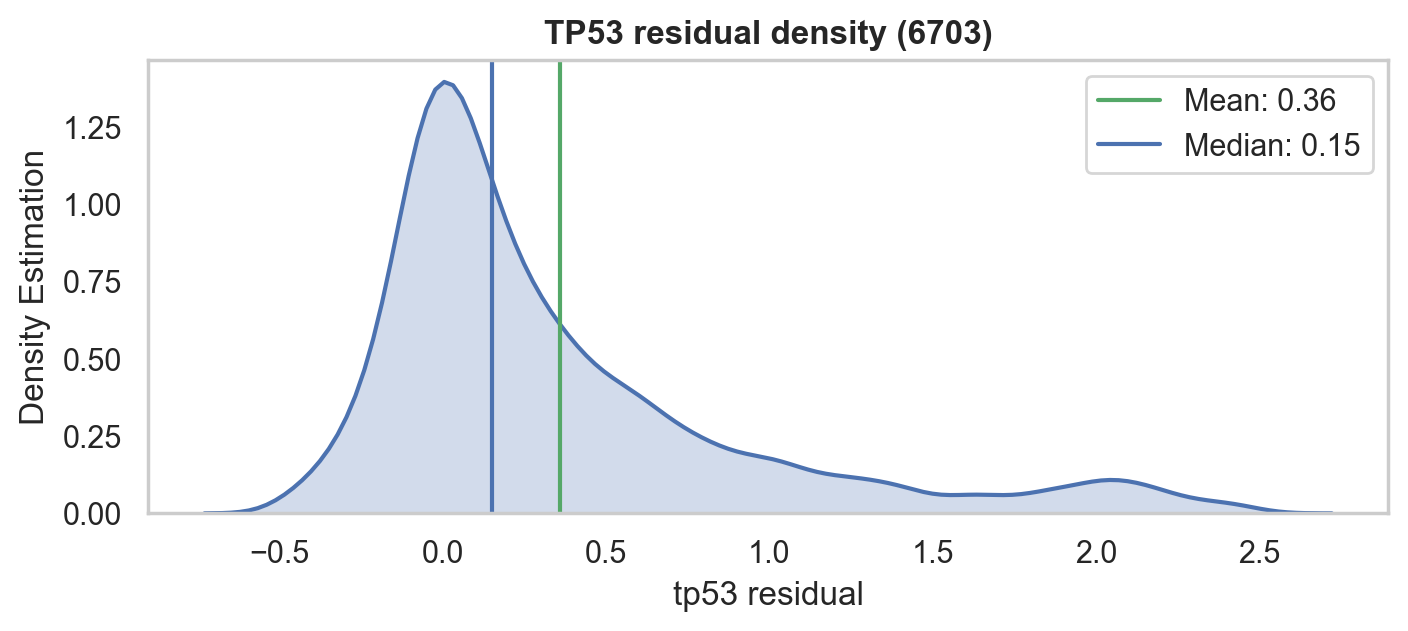

In [406]:
plot_density(xlabel='tp53 residual', 
             ylabel='Density Estimation', 
             title='', 
             clip=(-0.5,2.5),
             group = None,  
             figsize=(8,3))

Now, let's have a look at tp53 residual distributions for different cn_state, it will allow us to fine tune our thresholds.

In [401]:
get_groupby(gene_level_tp53_wgd, 'cn_state', 'count').sort_values(by='count', ascending=False)

,count
cn_state,
LOSS BEFORE,3876
CNLOH BEFORE & LOSS,1594
CNLOH BEFORE,420
LOSS AFTER,385
DOUBLE LOSS AFTER,136
TETRAPLOID,124
CNLOH AFTER,88
CNLOH BEFORE & GAIN,80


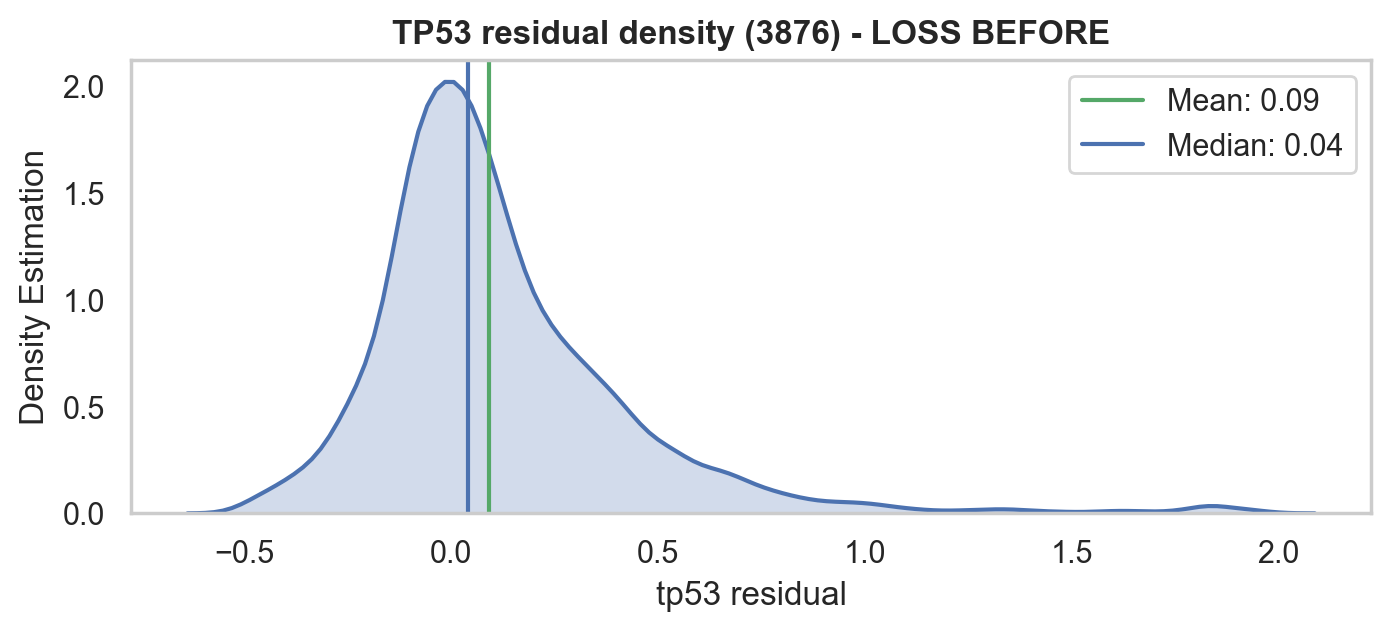

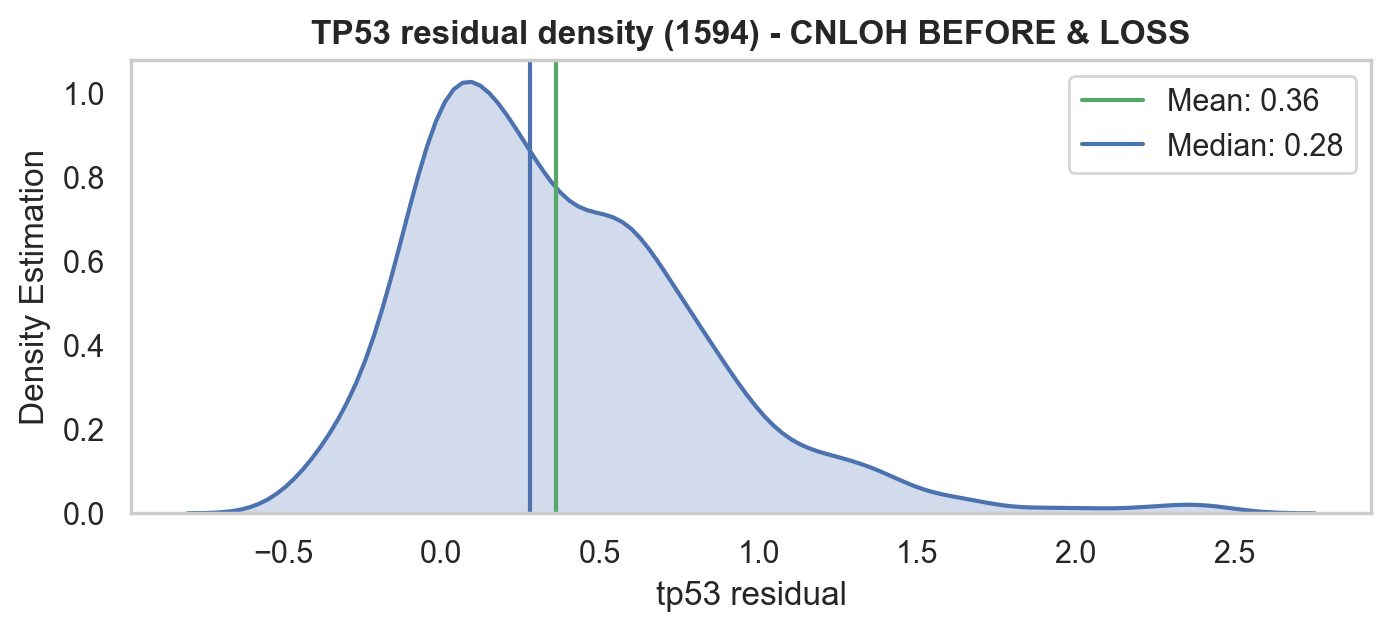

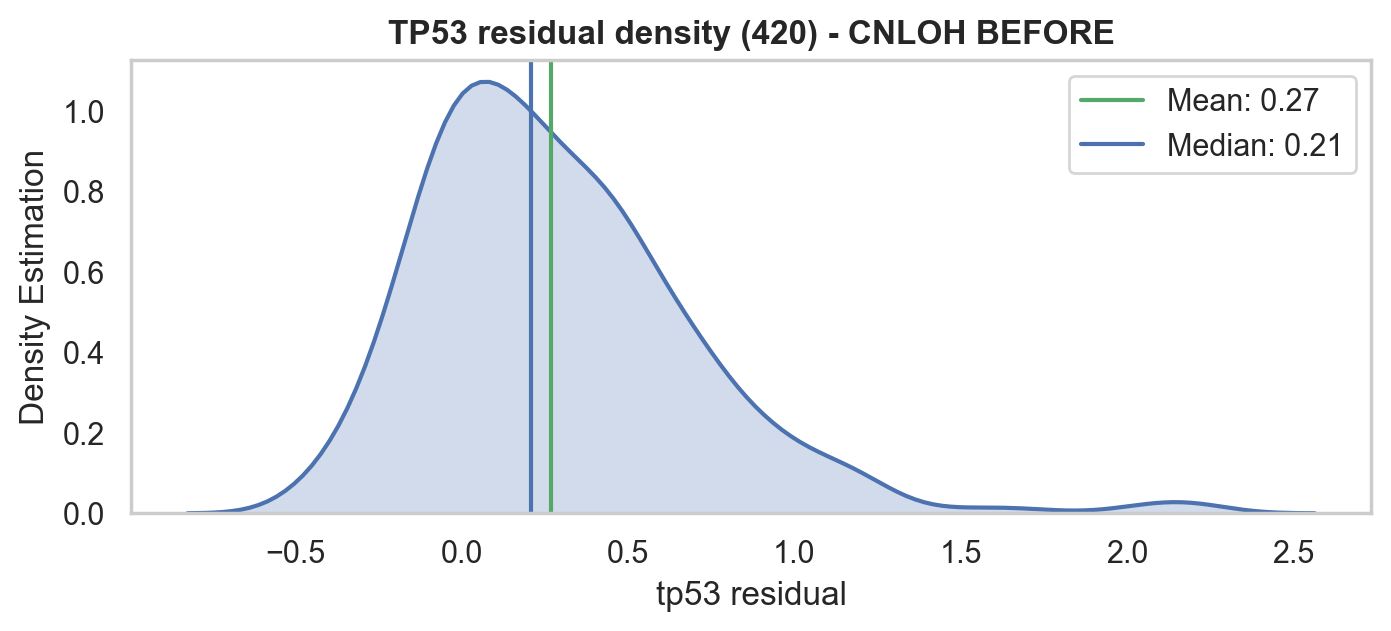

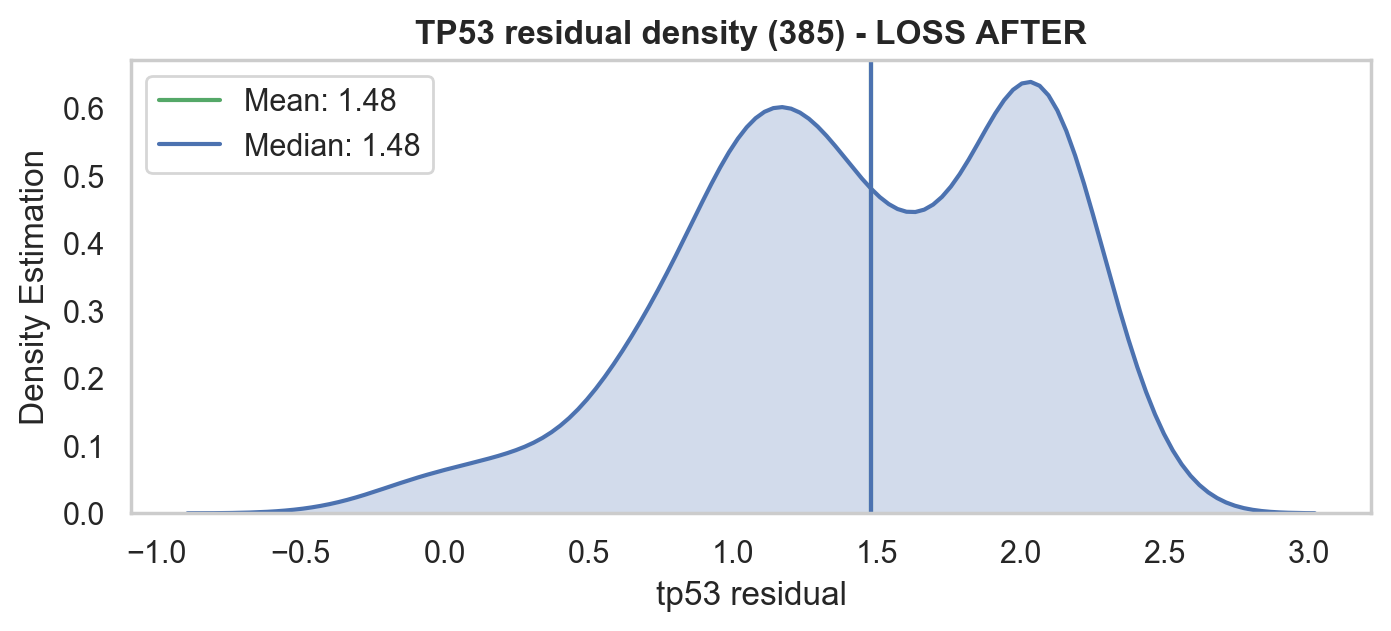

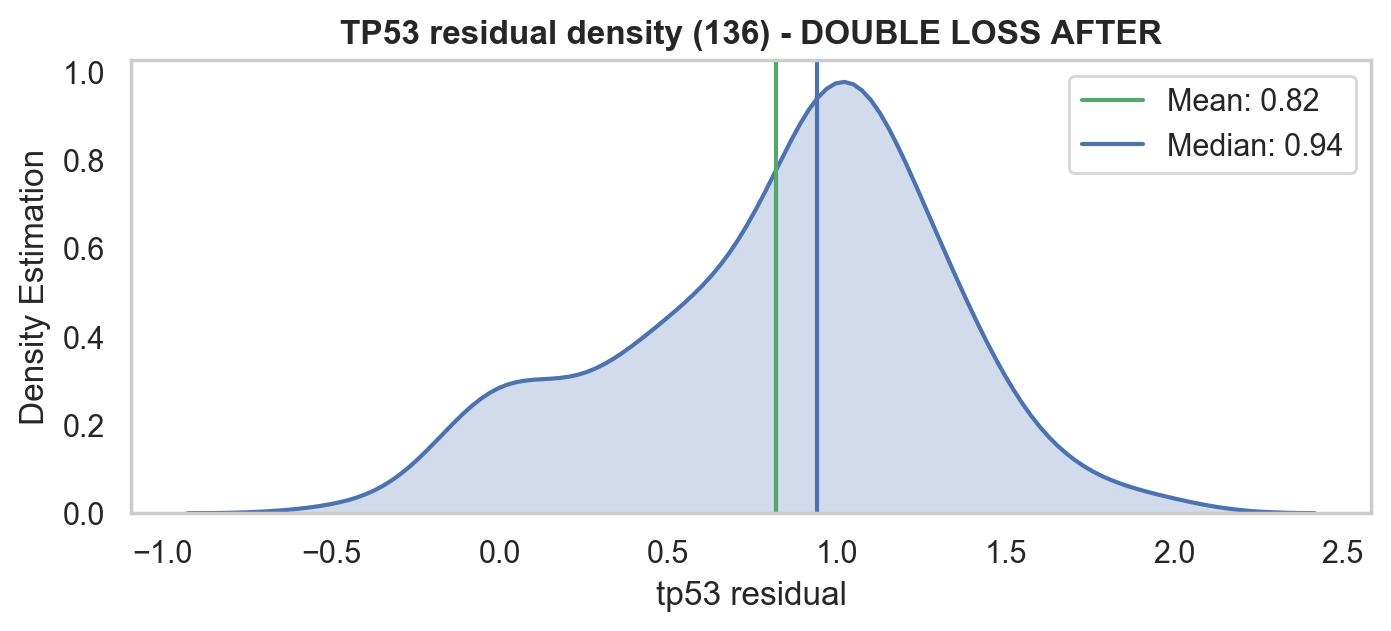

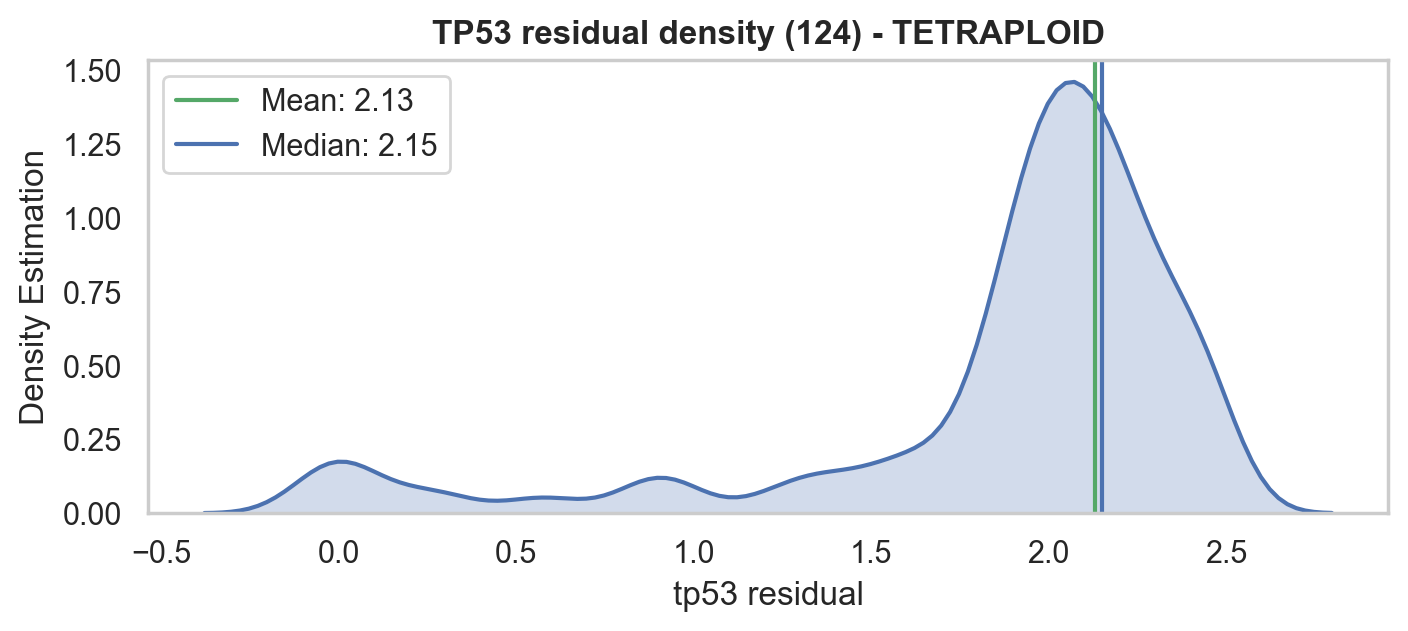

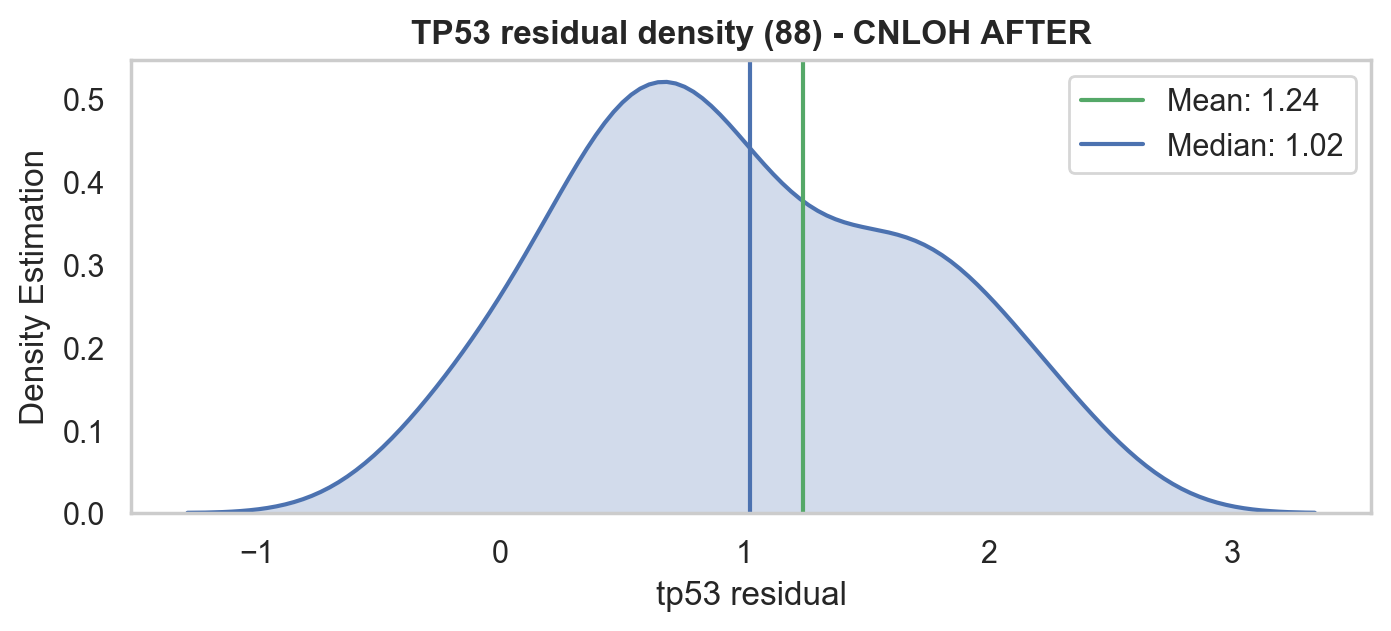

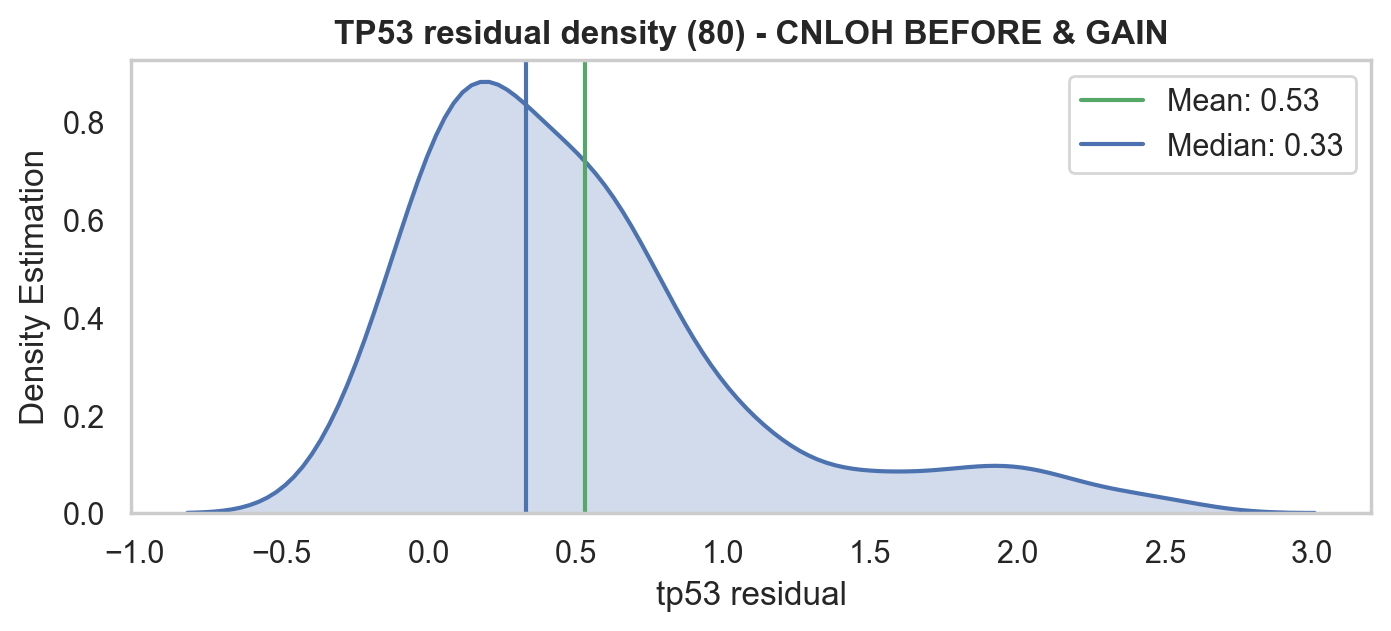

In [411]:
for group in ['LOSS BEFORE', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'LOSS AFTER', 'DOUBLE LOSS AFTER',
             'TETRAPLOID', 'CNLOH AFTER', 'CNLOH BEFORE & GAIN']:
    plot_density(xlabel='tp53 residual', 
             ylabel='Density Estimation', 
             title=' - ' + group, 
             clip=(-0.5,2.5),
             group = group,  
             figsize=(8,3))
    
'''

            NUMBER OF TP53 residual ASSOCIATED WITH ALLELIC STATE BEFORE WGD
            
            
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            0      |        1       | -
                CNLOH BEFORE & LOSS:     0      |       1,2      | 2
                CNLOH BEFORE:            0      |        2       | 3
                LOSS AFTER:              -      |       1,2      | 2
                DOUBLE LOSS AFTER:       -      |       0,1      | 1
                TETRAPLOID:              -      |        2       | 3
                CNLOH AFTER:             -      |       1,3      | 3
                CNLOH BEFORE & GAIN:     0      |        3       | 4
                

                    CURRENT THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD
                    
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            <0.5   |        >0.5    | -
                CNLOH BEFORE & LOSS:     <0.5   |      0.5< <1   | >1
                CNLOH BEFORE:            <1     |      1< <2.5   | >2.5
                LOSS AFTER:              -      |      <1.25     | >1.25 
                DOUBLE LOSS AFTER:       -      |       <0.25    | >0.25
                TETRAPLOID:              -      |       <2.5     | >2.5
                CNLOH AFTER:             -      |       <1.5     | >1.5
                CNLOH BEFORE & GAIN:     <1.5   |        <3.5    | >3.5
                
                
                
                
                NEW THRESHOLDS BETWEEN ALLELIC STATES BEFORE WGD
                    
                                     BI-ALLELIC | MONO - ALLELIC | 2WT

                LOSS BEFORE :            <0.5   |        >0.5    | -  0.4-0.6
                CNLOH BEFORE & LOSS:     0      |       1,2      | 2  0.4-0.6
                CNLOH BEFORE:            0      |        1.5     | 2.5  
                LOSS AFTER:              -      |       <1.5     |   >1.5 UNCERTAIN
                DOUBLE LOSS AFTER:       -      |       0,1      | 1  >0.5 UNCERTAIN
                TETRAPLOID:              -      |        2       | 3  >2.5 2WT
                CNLOH AFTER:             -      |       1,3      | 3 >1.5 UNCERTAIN
                CNLOH BEFORE & GAIN:     <1.5   |        1.5     | 3,4   1.4-1.6  >2.5 Incertain
                



 '''

# Saving different cohort files
We want to create 2 master files: one for the WGD cohort, and one for the non WGD cohort.

For that purpose we save the 4 filtered files in 2 different directories:
* '../../../data/impact-facets-tp53/procesed/wgd'
* '../../../data/impact-facets-tp53/procesed/no_wgd'

## Non WGD cohort

In [475]:
# We filter only Non WGD Samples
cohort_nowgd = cohort[cohort['wgd'] == False]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_nowgd = list(set(cohort_nowgd.tumor_sample))
samples_matched_nowgd = list(set(cohort_nowgd.sample_id))

In [476]:
# now we create:

# maf_cohort
maf_cohort_nowgd = maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_nowgd)]

#gene_level file
gene_level_nowgd = gene_level[gene_level['sample'].isin(samples_matched_nowgd)]

#arm_level file
arm_level_nowgd = arm_level[arm_level['sample'].isin(samples_matched_nowgd)]

In [478]:
# We just check that we have the same amount of samples in each
assert (len(set(maf_cohort_nowgd.Tumor_Sample_Barcode)) == len(samples_nowgd))
assert(len(set(gene_level_nowgd['sample'])) == len(samples_nowgd))
assert(len(set(arm_level_nowgd['sample'])) == len(samples_nowgd))
print(len(samples_nowgd))

18932


In [479]:
# Save the files
nowgd_path = '../../../data/impact-facets-tp53/processed/no_wgd/'
cohort_nowgd.to_csv(nowgd_path + 'cohort_nowgd.txt', sep='\t')
maf_cohort_nowgd.to_csv(nowgd_path + 'maf_cohort_nowgd.txt', sep='\t')
gene_level_nowgd.to_csv(nowgd_path + 'gene_level_nowgd.txt', sep='\t')
arm_level_nowgd.to_csv(nowgd_path + 'arm_level_nowgd.txt', sep='\t')

## WGD cohort

In [480]:
# We filter only Non WGD Samples
cohort_wgd = cohort[cohort['wgd'] == True]

# We store tumor sample ids and matched normal sample ids to filter gene_level anf maf_cohort
samples_wgd = list(set(cohort_wgd.tumor_sample))
samples_matched_wgd = list(set(cohort_wgd.sample_id))

In [481]:
# now we create:

# maf_cohort
maf_cohort_wgd = maf_cohort[maf_cohort['Tumor_Sample_Barcode'].isin(samples_wgd)]

#gene_level file
gene_level_wgd = gene_level[gene_level['sample'].isin(samples_matched_wgd)]

#arm_level file
arm_level_wgd = arm_level[arm_level['sample'].isin(samples_matched_wgd)]

In [482]:
# We just check that we have the same amount of samples in each
assert (len(set(maf_cohort_wgd.Tumor_Sample_Barcode)) == len(samples_wgd))
assert(len(set(gene_level_wgd['sample'])) == len(samples_wgd))
assert(len(set(arm_level_wgd['sample'])) == len(samples_wgd))
print(len(samples_wgd))

9898


In [483]:
# Save the files
wgd_path = '../../../data/impact-facets-tp53/processed/wgd/'

cohort_wgd.to_csv(wgd_path + 'cohort_wgd.txt', sep='\t')
maf_cohort_wgd.to_csv(wgd_path + 'maf_cohort_wgd.txt', sep='\t')
gene_level_wgd.to_csv(wgd_path + 'gene_level_wgd.txt', sep='\t')
arm_level_wgd.to_csv(wgd_path + 'arm_level_wgd.txt', sep='\t')

# Tests

In [59]:
# test to count the number of mutations per sample
sample_muts = maf_cohort_wgd[maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0025956-T01-IM6'][maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6'][maf_cohort['Hugo_Symbol'] == 'TP53'].drop_duplicates(subset='sample_mut_key')
sample_muts.shape[0]

0

In [54]:
maf_cohort_wgd[maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6'][maf_cohort_wgd.Tumor_Sample_Barcode == 'P-0023546-T02-IM6']

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,Caller,is-a-hotspot,is-a-3d-hotspot,mutation_effect,oncogenic,LEVEL_1,LEVEL_2A,LEVEL_2B,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,LEVEL_R3,Highest_level,citations,driver,tcn,lcn,cf,purity,t_var_freq,expected_alt_copies,ccf_Mcopies,ccf_Mcopies_lower,ccf_Mcopies_upper,ccf_Mcopies_prob95,ccf_Mcopies_prob90,ccf_1copy,ccf_1copy_lower,ccf_1copy_upper,ccf_1copy_prob95,ccf_1copy_prob90,ccf_expected_copies,ccf_expected_copies_lower,ccf_expected_copies_upper,ccf_expected_copies_prob95,ccf_expected_copies_prob90,facets_fit,reviewer_set_purity,use_only_purity_run,use_edited_cncf,cncf_file_used,LOH
111,CTNNB1,1499,MSKCC,GRCh37,3,41266098,41266098,+,Missense_Mutation,SNP,A,A,C,novel,NaN,P-0023546-T02-IM6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,NaN,NaN,c.95A>C,p.Asp32Ala,p.D32A,ENST00000349496,3/15,386.0,339.0,47.0,390,390,0,"CTNNB1,missense_variant,p.Asp32Ala,ENST00000349496,NM_001904.3;CTNNB1,missense_variant,p.Asp32Ala,ENST00000396185,NM_001098209.1;CTNNB1,missense_variant,p.Asp32Ala,ENST00000396183,NM_001098210.1;CTNNB1,missense_variant,p.Asp25Ala,ENST00000453024,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000405570,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000450969,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000431914,;CTNNB1,missense_variant,p.Asp32Ala,ENST00000441708,;CTNNB1,missense_variant,p.Asp25Ala,ENST00000426215,;CTNNB1,downstream_gene_variant,,ENST00000433400,;CTNNB1,non_coding_transcript_exon_variant,,ENST00000488914,;,regulatory_region_variant,,ENSR00000203589,;",C,ENSG00000168036,ENST00000349496,Transcript,missense_variant,375/3729,95/2346,32/781,D/A,gAc/gCc,NaN,1,NaN,1,CTNNB1,HGNC,2514.0,protein_coding,YES,CCDS2694.1,ENSP00000344456,P35222,"G9GAG7,E9PDF9,E7EV28,E7EMJ5,C9IZ65,B4DGU4",UPI000012862F,NM_001904.3,deleterious(0),probably_damaging(0.959),3/15,NaN,"hmmpanther:PTHR23315,hmmpanther:PTHR23315:SF53",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MODERATE,1.0,SNV,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,GAC,.,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,Gain-of-function,Likely Oncogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15829978,True,6.0,3.0,0.312907,0.312907,0.121762,1.0,0.422,0.357,0.493,2.583183e-13,1.732627e-11,1.000,0.944,1.000,0.545539,0.816613,1.000,0.944,1.000,0.545539,0.816613,/juno/work/ccs/shared/resources/impact/facets/all/P-00235/P-0023546-T02-IM6_P-0023546-N01-IM6//default,NaN,False,False,/juno/work/ccs/shared/resources/impact/facets/all/P-00235/P-002354

In [125]:
# We will merge maf_cohort and gene_level in order to count the samples that have at least one tp53 event (either
# tp53 mutation or tp53 CN event)
# We add the WGD information to know if DIPLOID or TETRAPLOID is our baseline in terms of tp53 CN

# First we select the columns
maf_cohort_merge = maf_cohort_wgd[['Tumor_Sample_Barcode', 'Hugo_Symbol']]
gene_level_merge = gene_level_tp53_wgd[['tumor_id', 'cn_state']]
cohort=cohort[['tumor_sample', 'wgd']]

# We merge
tp53_hit = pd.merge(maf_cohort_merge, gene_level_merge, how='left', left_on='Tumor_Sample_Barcode', right_on='tumor_id')
tp53_hit = pd.merge(tp53_hit, cohort, how='left', left_on='Tumor_Sample_Barcode', right_on='tumor_sample')


In [126]:
tp53_hit.columns = ['tumor_id', 'Hugo_Symbol', 'tumor_id_bis', 'tp53_cn_state', 'tumor_id_ter', 'wgd']
tp53_hit = tp53_hit.drop(['tumor_id_bis', 'tumor_id_ter'], axis=1)

,tumor_id,Hugo_Symbol,tp53_cn_state,wgd
0,P-0025956-T01-IM6,KRAS,LOSS AFTER,True
1,P-0025956-T01-IM6,STK11,LOSS AFTER,True
2,P-0025956-T01-IM6,KEAP1,LOSS AFTER,True
3,P-0025956-T01-IM6,SMARCA4,LOSS AFTER,True
4,P-0025956-T01-IM6,PTPRT,LOSS AFTER,True
...,...,...,...,...
90473,P-0049537-T01-IM6,ELF3,HETLOSS,True
90474,P-0049537-T01-IM6,KRAS,HETLOSS,True
90475,P-0049537-T01-IM6,TP53,HETLOSS,True
90476,P-0049537-T01-IM6,RNF43,HETLOSS,True


In [45]:
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
# We eliminate unmatched samples
master = master[master['Somatic_Status']!='Unmatched']
#We eliminate samples with too low purity
samples_cutoff = list(master[master['purity'] > 0.20]['Tumor_Id'])
samples_na = list(master[master['purity'].isna()]['Tumor_Id'])
samples_cutoff = samples_cutoff + samples_na
master_cutoff = master[master.Tumor_Id.isin(samples_cutoff)]